# Initial

## Imports

In [26]:
import pandas as pd
import numpy as np
import os
import itertools
from collections import Counter

from combat.pycombat import pycombat

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from skopt import BayesSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from time import time

## Code

### Fixing Datasets

In [78]:
def import_csv_files(path, starts_with, ends_with = ".csv"):
    """Imports csv files based on path and starting characters.

    :param path: Path of where to find csv files.
    :param starts_with: Starting characters of dataframes to find.
    :param ends_with: Type of file to load.
    :return: List of loaded csv files.
    """    
    file_list = []
    for filename in os.listdir(path):
        if filename.startswith(starts_with) and filename.endswith(ends_with):
            file_path = os.path.join(path, filename)
            file_list.append(pd.read_csv(file_path))
    return file_list

In [79]:
def same_shape(dfs : list):
    """Checks if all dataframes in a list have the same shape.

    :param dfs: List of dataframes.
    :return: Boolean value if all dataframes have the same shape.
    """    
    return all(df.shape == dfs[0].shape for df in dfs)

In [80]:
def get_average_from_m_datasets(dfs : list):
    """Pools imputed dataset into a single dataframe.

    :param dfs: List of dataframes.
    :return: Singular, pooled dataframe.
    """    
    if not same_shape:
        print("Dataframes must have the same shape")
    joined = pd.concat(dfs).reset_index() 
    return joined.groupby('index').mean()

### Cleaning and Perturbation

In [81]:
def run_combat(df, TMT_set_indices):
    """Run ComBat to reduce batch effect on a dataframe.

    :param df: Dataframe that ComBat is runned on
    :param TMT_set_indices: Labels of which TMT batch each row belongs to.
    :return: DF with ComBat applied to it
    """    
    return pycombat(df.T, TMT_set_indices).T

In [82]:
def add_noise(df, n_samples, std = 0.1):
    """Helper function for simple perturbation function. Adds gaussian noise to randomly sampled rows of the df passed as an argument.

    :param df: df filtered on class
    :param n_samples: Number of samples to perform random sampling on
    :param std: Standard deviation. Defaults to 0.1.
    :return: df with added perturbed samples
    """      
    sampled_df = df.sample(n = n_samples, replace = True)
    gaussian_noise = np.random.normal(0, std, size=sampled_df.shape)
    return sampled_df + gaussian_noise

In [83]:
def simple_perturbation(X, y, n_samples_per_class = None, std = 0.1):
    """Performs a simple perturbation by sampling random rows of classes and adds gaussian noise to them

    :param X: Dataframe with samples to get perturbed
    :param y: Class labels
    :param n_samples_per_class: Decides how many samples per class that are going to be sampled, defaults to None. 
    If none -> all classes will get equal weight according to size of current largest class.
    :param std: How much the noise can deviate from the mean (Standard dev.), defaults to 0.1
    :return: A df with the perturbed samples. A list stating which row belongs to which class.
    """    
    classes = y.value_counts()
    if n_samples_per_class is None:
        largest_class = classes.argmax()
        largest_n_samples = classes.pop(largest_class)
    else:
        largest_n_samples = n_samples_per_class
    df_list = []
    y_new_classes = list(y)
    for idx, n_samples in classes.items():
        perturbed = add_noise(X[y == idx], largest_n_samples - n_samples, std=std)
        df_list.append(perturbed)
        y_new_classes = y_new_classes + [idx] * len(perturbed)
    return pd.concat([X] + df_list, axis=0), y_new_classes

### GridSearch and Feature Importance

In [84]:
def get_best_params(X, y, models, params, cv = 5, n_jobs = -1):
    """Runs GridSearchCV in order to find best parameters on one or more models.

    :param X: The training data for the models.
    :param y: The correct classification of the training data.
    :param models: A list of models to be trained.
    :param params: A dictionary with the parameters for each model to be GridSearched.
    :param cv: The K-fold cross validation value.
    :param n_jobs: Number of cores to use for GridSearchCV.

    :return: DF with ComBat applied to it
    """   
    best_params = {}
    for model, param in zip(models, params):
        start_time = time()
        print(f"\033[97m{model.name} started.")
        clf = GridSearchCV(model, param_grid=param, cv=cv, n_jobs=n_jobs, scoring="f1_weighted")
        clf.fit(X, y)
        best_params[model.name] = clf.best_params_
        print(f"{model.name} is done in {time() - start_time} seconds.\n" )
    return best_params

In [106]:
def get_best_params_bayes(X, y, models, params, n_iter = 10, cv = 3, n_jobs = -1):
    """Runs GridSearchCV in order to find best parameters on one or more models.

    :param X: The training data for the models.
    :param y: The correct classification of the training data.
    :param models: A list of models to be trained.
    :param params: A dictionary with the parameters for each model to be GridSearched.
    :param cv: The K-fold cross validation value.
    :param n_jobs: Number of cores to use for GridSearchCV.

    :return: DF with ComBat applied to it
    """   
    best_params = {}
    for model, param in zip(models, params):
        start_time = time()
        print(f"\033[97m{model.name} started.")
        clf = BayesSearchCV(model, search_spaces=param, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring="f1_weighted")
        clf.fit(X, y)
        best_params[model.name] = clf.best_params_
        print(f"{model.name} is done in {time() - start_time} seconds.\n" )
    return best_params

In [86]:
def get_average_feature_importance_XGB_RF(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    :return: Dictionary with column name as keys and average feature importance as values.
    """  
    avg_feature_importance = {}
    for model in models:
        importances = model.feature_importances_
        for index, importance in enumerate(importances):
            name = df.columns[index]
            if name in avg_feature_importance:
                avg_feature_importance[name] += importance
            else:
                avg_feature_importance[name] = importance
    for feature, total in avg_feature_importance.items():
        mean = total / len(models)
        avg_feature_importance[feature] = mean
    
    return avg_feature_importance

In [87]:
def get_average_feature_importance_LR(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    :return: Dictionary with column name as keys and average feature importance as values.
    """  
    all_coefficients = []
    feature_names = df.columns.tolist()
    
    for model in models:
        coefficients = model.coef_[0]
        abs_coefficients = np.abs(coefficients)
        all_coefficients.append(abs_coefficients)
    
    avg_coefficients = np.mean(all_coefficients, axis=0)
    normalized_coefficients = avg_coefficients / np.sum(avg_coefficients)
    feature_importance = dict(zip(feature_names, normalized_coefficients))
    
    return feature_importance

In [88]:
def get_average_feature_importance(d, model_name, df):
    """Wrapper function in order to extract average feature importance across multiple iterations of multiple models.

    :param d: Dictionary with models.
    :param model_name: Name of the model.
    :param df: Original dataframe in order to map feature importances to column names.
    :return: Dictionary with column name as keys and average feature importance as values.
    """  
    models = [model for key, model in d.items() if key.startswith(f'{model_name}')]
    if model_name == "LR":
        return get_average_feature_importance_LR(models, df)
    return get_average_feature_importance_XGB_RF(models, df)

### Voting

In [89]:
def hard_voting(models):
    """Hard voting based on predictions from multiple models.

    :param models: List of trained models.
    :return: Hard voting results.
    """  
    predictions = [model.prediction for model in models]
    predictions = [[row[i] for row in predictions] for i in range(len(predictions[0]))]
    results = []
    for index, p in enumerate(predictions):
        most_common = Counter(p).most_common()
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            probabilities = [model.probability[index] for model in models]
            probabilities = [[row[i] for row in probabilities] for i in range(len(probabilities[0]))]
            probabilities = [sum(sublist) for sublist in probabilities]
            if len(most_common) > 2 and most_common[0][1] == most_common[2][1]:
                results.append(np.argmax(probabilities))
            else:
                probabilities[most_common[2][0]] = 0
                results.append(np.argmax(probabilities))
        else:
            results.append(most_common[0][0])

    return results  

In [90]:
def summed_votes(pred_proba):
    """Summs the soft vote prediction probability together.

    :param pred_proba: The prediciton probability from the different models.
    :return: The summized prediction probability.
    """  
    length = len(pred_proba[0])
    summed_columns = []

    for i in range(length):
        column_sum = np.sum([preds[i] for preds in pred_proba], axis=0)
        summed_columns.append(column_sum)

    return summed_columns

In [91]:
def soft_voting(models):
    """Soft voting based on predictions from multiple models.

    :param models: List of trained models.
    :return: Soft voting results.
    """  
    probabilities = [model.probability for model in models]
    probabilities = [[row[i] for row in probabilities] for i in range(len(probabilities[0]))]
    results = []
    for p in probabilities:
        vote = summed_votes(p)
        results.append(np.argmax(vote))
    return results

### Plotting Code

In [92]:
def plot_confusion_matrix(ax, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.

    :param ax: Axis to print confusion matrix on.
    :param cm: Pre-made sklearn confusion matrix.
    :param classes: Values of predicted classes.
    :param normalize: If True, normalizes the values between 0 and 1.
    :param title: Title of confusion matrix.
    :param cmap: Colour of confusion matrix.
    """ 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [93]:
def plot_soft_vote_confusion_matrix(y_real, y_pred, title="Confusion Matrix"):
    """Wrapper function for plot_confusion_matrix.

    :param y_real: The real y class.
    :param y_pred: The predicted y class.
    """      
    cnf_matrix = confusion_matrix(y_real, y_pred)
    np.set_printoptions(precision=2)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    plot_confusion_matrix(axs[0], cnf_matrix, classes=['CN', 'MCI', 'AD'],
                          title=f'{title}, no normalization')

    plot_confusion_matrix(axs[1], cnf_matrix, classes=['CN', 'MCI', 'AD'], normalize=True,
                          title=f'{title}, normalized')

    plt.show()

In [94]:
def plot_percentiles(percentiles, labels, title="Accuracy scores"):
    """
    Plot percentiles against labels.

    :param percentiles: List of percentiles.
    :param labels: List of strings (labels).
    """
    x = range(len(labels))
    
    plt.figure(figsize=(8, 6))
    plt.bar(x, percentiles, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, labels)
    plt.ylim(0, 1)
    plt.show()

In [95]:
def plot_feature_importance(dict1, dict2, dict3, models=["Model1", "Model2", "Model3"], main_model = None, colours = ["b", "g", "r"]):
    """
    Plots feature importance from three dictionaries.

    :param dict: 
    :param labels: List of strings (labels).
    """
    sorted_dict1 = dict(sorted(dict1.items(), key=lambda item: item[1], reverse=True))
    top_features_dict1 = list(sorted_dict1.items())[:15]
    top_features_keys = [key for key, _ in top_features_dict1]

    feature_importance_dict1 = [val for _, val in top_features_dict1]
    feature_importance_dict2 = [dict2[key] for key in top_features_keys]
    feature_importance_dict3 = [dict3[key] for key in top_features_keys]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar([i - 0.2 for i in range(15)], feature_importance_dict1, width=0.2, color=colours[0], label=models[0])
    ax.bar([i for i in range(15)], feature_importance_dict2, width=0.2, color=colours[1], label=models[1])
    ax.bar([i + 0.2 for i in range(15)], feature_importance_dict3, width=0.2, color=colours[2], label=models[2])

    ax.set_xticks(range(15))
    ax.set_xticklabels(top_features_keys, rotation=90)
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title(f"Top 15 feature from {main_model}")
    ax.legend()

    plt.tight_layout()
    plt.show()

### Main Pipeline

In [103]:
def create_models(iteration):
    """Creates 3 new basemodels with names depending on iteration.

    :param iteration: Current iteration in K-Fold cross validation.
    :return: List of base models.
    """      
    xgboost = XGBClassifier()
    xgboost.name = f"XGB {iteration}"
    #lr = LogisticRegression()
    #lr.name = f"LR {iteration}"
    #rf = RandomForestClassifier()
    #rf.name = f"RF {iteration}"

    return [xgboost]#, lr, rf]

In [107]:
def pipeline(X, y, params, tmt_set = None, K = 10, n_samples_per_class = 100):
    """Main pipeline code that runs K-fold validation.

    :param X: Dataframe of X values for training.
    :param y: Pandas series of real class values for training 
    :param params: Parameter settings to get best parameters from.
    :param tmt_set: Pandas series with indexes for batches from TMT sets.
    :param K: Number of K-fold iterations to run.
    :param n_samples_per_class: Number of samples per class that should exist after perturbation.
    :return: -
    """  
    all_models = {}
    votes = {}
    y_true = {}
    k_fold = StratifiedKFold(n_splits=K, shuffle=True)
    print("\n-------------- Starting K-fold cross validation: --------------\n")
    for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
        print(f"\033[94mK-Fold validation: Iteration {i}.")
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        X_train, y_train = simple_perturbation(X_train, y_train, n_samples_per_class=n_samples_per_class)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        models = create_models(i)
        best_params = get_best_params_bayes(X_train, y_train, models, params)
        y_true[f'{i}'] = y_test
        best_models = []
        for model in models:
            best_model = model.__class__(**best_params[model.name])
            best_model.name = model.name
            best_model.fit(X_train, y_train)
            best_model.prediction = best_model.predict(X_test)
            best_model.probability = best_model.predict_proba(X_test)
            all_models[best_model.name] = best_model
            best_models.append(best_model)
        hard = f'Hard vote {i}'
        soft = f'Soft vote {i}'
        votes[hard] = hard_voting(best_models)
        votes[soft] = soft_voting(best_models)
        print(f'\033[92mHard vote F1 score: {f1_score(y_test, votes[hard], average="weighted")}')
        print(f'\033[92mSoft vote F1 score: {f1_score(y_test, votes[soft], average="weighted")}\n')
    
    return all_models, votes, y_true

# Pipeline

## Data

In [27]:
#Loading dataframes, Pooling and classes.
path = "./Data/data files/imputed"
starts_with = "protein_lumbar"
dfs = import_csv_files(path=path, starts_with=starts_with)
df_main = get_average_from_m_datasets(dfs)

df_classes = pd.read_csv("./Data/data files/iNPH_data_protein_median.csv", usecols=["Cortical_biopsy_grouping", "CSF_type", "TMT Set"])
df_classes = df_classes[df_classes["CSF_type"] == "L"].reset_index(drop=True)
tmt_set = df_classes["TMT Set"]
y = df_classes["Cortical_biopsy_grouping"]

df_main = run_combat(df_main, tmt_set)

Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


## Parameters for GridSearchCV

In [113]:
#Good overall results
#XGBoost better than RF, but very slow
#LR Strong, and super fast
#Build more on RF?
xgboost_params = {"eta": [0.1, 0.2, 0.3],
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10],
                  "reg_lambda": [0.7, 0.85, 1],
                  "max_depth": [3, 4, 5, 6, 10, 20],
                  "n_estimators": [100,150,200]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 6000, 8000, 10000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [300, 400],
             "criterion": ["gini", "entropy", "log_loss"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt", "log2"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params = [xgboost_params, lr_params, rf_params]

In [166]:
#FASTER, HARDER, SCOOTER
xgboost_params = {"eta": [0.2, 0.3],#
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.01, 1],
                  "subsample": [0.4, 0.8],
                  "reg_lambda": [0.85],
                  "lambda": [0.5, 0.7],
                  "max_depth": [4, 6],#
                  "n_estimators": [150]}#
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.01, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0, 0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [300, 400],
             "criterion": ["gini", "entropy", "log_loss"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt", "log2"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params = [xgboost_params, lr_params, rf_params]

## K-Fold-Pipeline

In [44]:
#Run Pipeline
all_models, votes, y_true = pipeline(df_union, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\space\space.py:110: UserWarning: Dimension [0.85, 1] was inferred to Real(low=0.85, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.85, 1), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\space\space.py:110: UserWarning: Dimension [0.85, 1] was inferred to Real(low=0.85, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.85, 1), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\space\space.py:110: UserWarning: Dimension [0.85, 1] was inferred to Real(low=0.85, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it

XGB 0 is done in 142.8471794128418 seconds.

LR 0 started.


KeyboardInterrupt: 

## Results

In [168]:
#Combining K-fold results.
hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

### Confusion Matrix (Average across all runs)

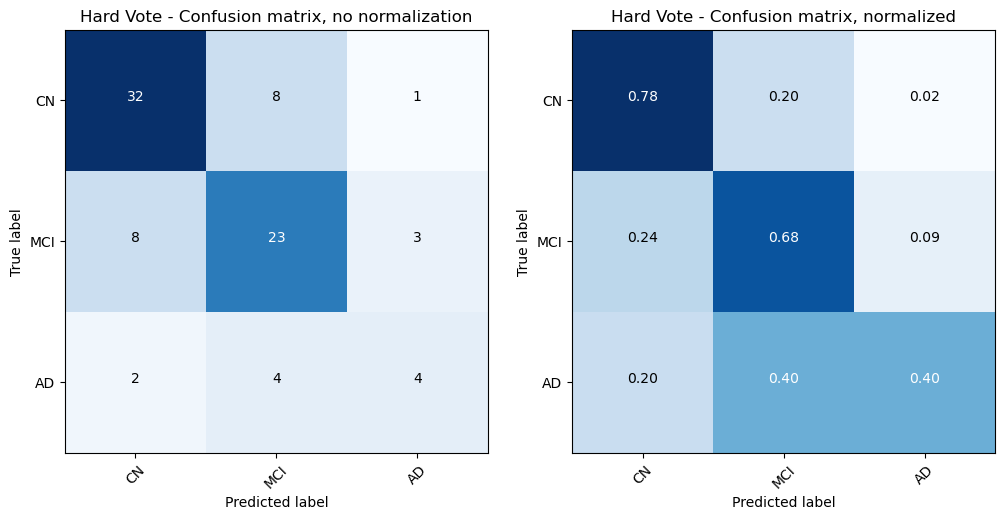

In [169]:
#Confusion Matrix (HARD VOTE).
plot_soft_vote_confusion_matrix(y_trues, hard_votes, title="Hard Vote - Confusion matrix")

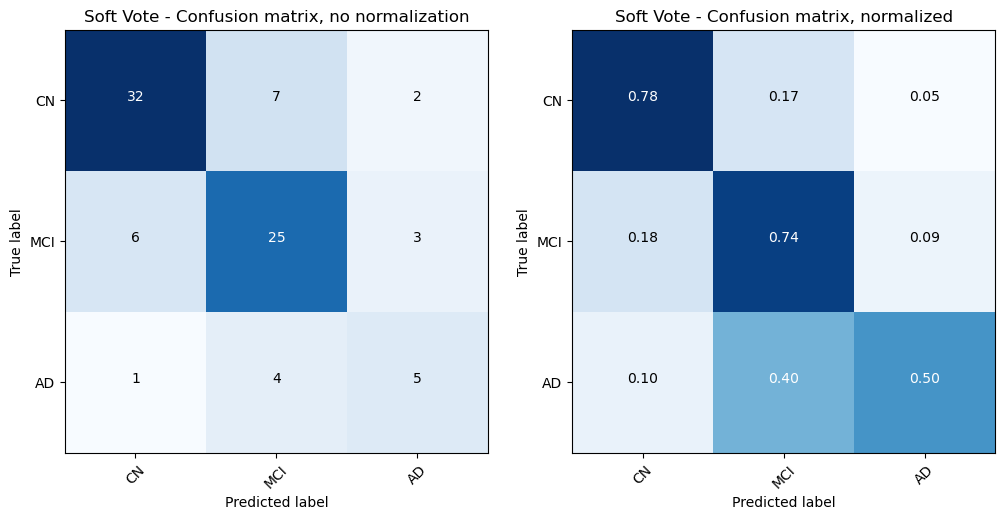

In [170]:
#Confusion Matrix (SOFT VOTE).
plot_soft_vote_confusion_matrix(y_trues, soft_votes, title="Soft Vote - Confusion matrix")

### Accuracy (Average across all runs)

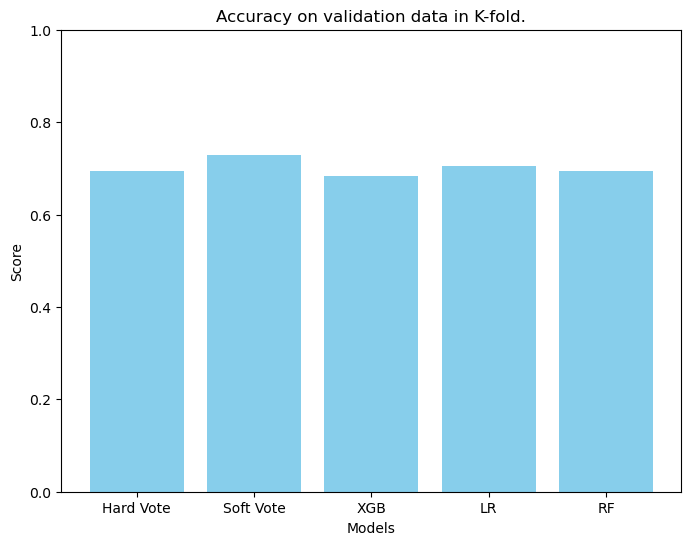

In [171]:
# Example usage:
percentiles = [accuracy_score(y_trues, hard_votes),
                accuracy_score(y_trues, soft_votes),
                accuracy_score(y_trues, xgb_votes),
                accuracy_score(y_trues, lr_votes),
                accuracy_score(y_trues, rf_votes)]
labels = ["Hard Vote", "Soft Vote", "XGB", "LR", "RF"]
plot_percentiles(percentiles, labels, "Accuracy on validation data in K-fold.")

### Feature Importance (Average across all runs)

In [172]:
RF_avg_feature_importance = get_average_feature_importance(all_models, "RF", df_main)
XGB_avg_feature_importance = get_average_feature_importance(all_models, "XGB", df_main)
LR_avg_feature_importance = get_average_feature_importance(all_models, "LR", df_main)

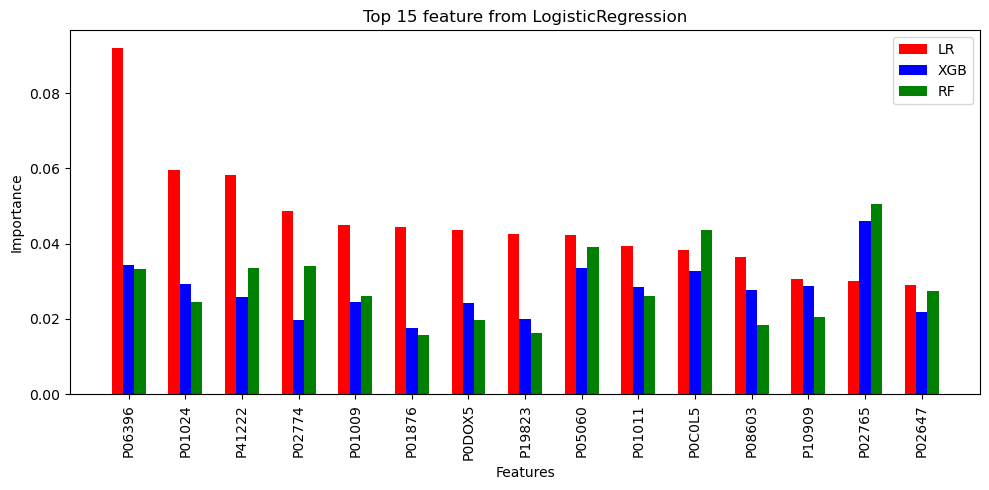

In [173]:
plot_feature_importance(LR_avg_feature_importance, XGB_avg_feature_importance, RF_avg_feature_importance, models=["LR", "XGB", "RF"], main_model="LogisticRegression", colours = ["r", "b", "g"])

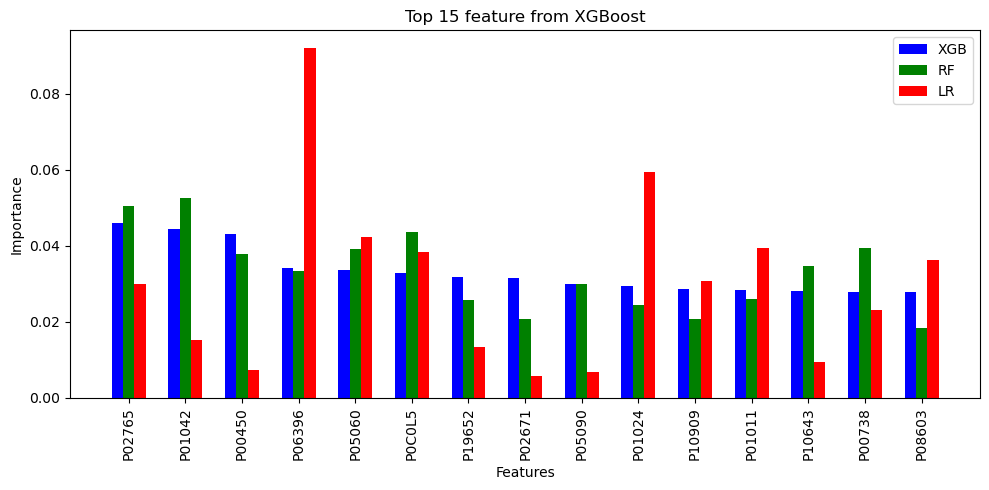

In [174]:
plot_feature_importance(XGB_avg_feature_importance, RF_avg_feature_importance, LR_avg_feature_importance, models=["XGB", "RF", "LR"], main_model="XGBoost", colours = ["b", "g", "r"])

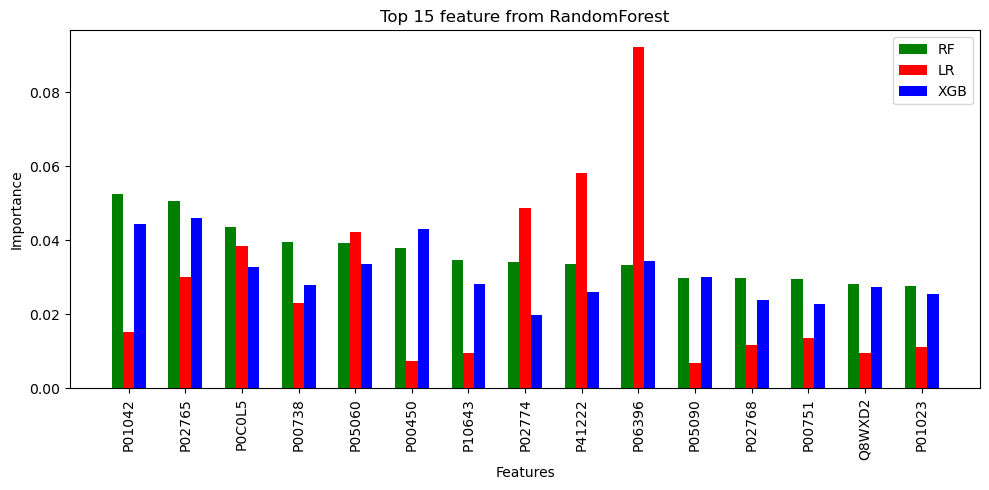

In [175]:
plot_feature_importance(RF_avg_feature_importance, LR_avg_feature_importance, XGB_avg_feature_importance, models=["RF", "LR", "XGB"], main_model="RandomForest", colours = ["g", "r", "b"])

In [176]:
print(f"XGB\t\tAUC OVR: {roc_auc_score(y_trues, xgb_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, xgb_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, xgb_votes)} \t\tF1: {f1_score(y_trues, xgb_votes, average='weighted')}")
print(f"LR \t\tAUC OVR: {roc_auc_score(y_trues, lr_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, lr_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, lr_votes)} \t\tF1: {f1_score(y_trues, lr_votes, average='weighted')}")
print(f"RF \t\tAUC OVR: {roc_auc_score(y_trues, rf_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, rf_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, rf_votes)} \t\tF1: {f1_score(y_trues, rf_votes, average='weighted')}")
print(f"Soft Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, soft_votes)} \t\tF1: {f1_score(y_trues, soft_votes, average='weighted')}")
print(f"Hard Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, hard_votes)} \t\tF1: {f1_score(y_trues, hard_votes, average='weighted')}")

XGB		AUC OVR: 0.850737008024374 		AUC OVO: 0.8458034433285508 		ACC: 0.6823529411764706 		F1: 0.6743868970909515
LR 		AUC OVR: 0.875592336565077 		AUC OVO: 0.8717120994739359 		ACC: 0.7058823529411765 		F1: 0.7139141972578505
RF 		AUC OVR: 0.8361570579625267 		AUC OVO: 0.8426590148254424 		ACC: 0.6941176470588235 		F1: 0.6890522875816993
Soft Vote											ACC: 0.7294117647058823 		F1: 0.730420168067227
Hard Vote											ACC: 0.6941176470588235 		F1: 0.6908890463816049


# Current Test Ideas

## Recursive Feature Extraction

We will add Stabl here in the future.

In [30]:
#Models based on GridSearchCV performance on prediciton.
lasso = Lasso(alpha=0.001, max_iter=5000)
lr = LogisticRegression(penalty='l1', solver="saga", multi_class="multinomial", max_iter=2000, C=0.18)
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=2)
xgb = XGBClassifier(eta=0.2, gamma=0.1, n_estimators=150, reg_alpha=0.5, reg_lambda=0.6, min_child_weight=0.45, subsample=0.55)

In [31]:
n_features_p1 = 100
step_p1 = 10

#LASSO
rfe_lasso = RFE(lasso, n_features_to_select=n_features_p1, step=step_p1)
_ = rfe_lasso.fit_transform(df_main, y=y)

#LR
rfe_lr = RFE(lr, n_features_to_select=n_features_p1, step=step_p1)
_ = rfe_lr.fit_transform(df_main, y=y)

#RF
rfe_rf = RFE(rf, n_features_to_select=n_features_p1, step=step_p1)
_ = rfe_rf.fit_transform(df_main, y=y)

#XGB
rfe_xgb = RFE(xgb, n_features_to_select=n_features_p1, step=step_p1)
_ = rfe_xgb.fit_transform(df_main, y=y)

In [32]:
#Feature Names.
lasso_cont = rfe_lasso.get_feature_names_out()
lr_cont = rfe_lr.get_feature_names_out()
rf_cont = rfe_rf.get_feature_names_out()
xgb_cont = rfe_xgb.get_feature_names_out()

#Dataframes based on extracted features.
df_lasso_cont = df_main[lasso_cont]
df_lr_cont = df_main[lr_cont]
df_rf_cont = df_main[rf_cont]
df_xgb_cont = df_main[xgb_cont]

In [33]:
n_features_p2 = 10
step_p2 = 1

#LASSO
rfe_lasso_p2 = RFE(lasso, n_features_to_select=n_features_p2, step=step_p2)
_ = rfe_lasso_p2.fit_transform(df_lasso_cont, y=y)

#LR
rfe_lr_p2 = RFE(lr, n_features_to_select=n_features_p2, step=step_p2)
_ = rfe_lr_p2.fit_transform(df_lr_cont, y=y)

#RF
rfe_rf_p2 = RFE(rf, n_features_to_select=n_features_p2, step=step_p2)
_ = rfe_rf_p2.fit_transform(df_rf_cont, y=y)

#XGB
rfe_xgb_p2 = RFE(xgb, n_features_to_select=n_features_p2, step=step_p2)
_ = rfe_xgb_p2.fit_transform(df_xgb_cont, y=y)

In [34]:
#Number of features in current dataset.
set_lasso_p2 = set(rfe_lasso_p2.get_feature_names_out())
set_lr_p2 = set(rfe_lr_p2.get_feature_names_out())
set_rf_p2 = set(rfe_rf_p2.get_feature_names_out())
set_xgb_p2 = set(rfe_xgb_p2.get_feature_names_out())

len(set_lasso_p2.union(set_lr_p2, set_rf_p2, set_xgb_p2))

36

In [35]:
#Dataset after feature extraction.
set_union = set_lasso_p2.union(set_lr_p2, set_rf_p2, set_xgb_p2)
list_union = list(set_union)
df_union = df_main[list_union]

# Old Code (DO NOT RUN)

## Peptide Feature Extraction (500, LASSO)

In [ ]:
#Peptide Dataset
#df_peptides_all = pd.read_csv("./Data/data files/iNPH_data_peptide_median.csv")
#df_peptides = df_peptides_all.iloc[:, 12:]
#df_peptides_zero = df_peptides.replace([np.nan, np.NaN], 0)
#
#df_peptides_lumbar = df_peptides_zero[df_peptides_all["CSF_type"] == "L"]
#df_peptides_ventricular = df_peptides_zero[df_peptides_all["CSF_type"] == "V"]
#
#y_lumbar = df_peptides_all[df_peptides_all["CSF_type"] == "L"]["Cortical_biopsy_grouping"]
#y_ventricular = df_peptides_all[df_peptides_all["CSF_type"] == "V"]["Cortical_biopsy_grouping"]
#
#Lumbar
#lasso_lumbar = Lasso(alpha=0.18, max_iter=5000)
#rfe_lumbar = RFE(lasso_lumbar, n_features_to_select=500, step=10)
#rfe_lumbar.fit(df_peptides_lumbar, y_lumbar)
#
#lumbar_features = df_peptides_lumbar.columns[rfe_lumbar.support_]
#df_peptides_lumbar_top500lasso = df_peptides[df_peptides_all["CSF_type"] == "L"][lumbar_features]
#df_peptides_lumbar_top500lasso.to_csv("peptide_lumbar_top500_lasso.csv", index=False)
#
#Ventricular
#lasso_ventricular = Lasso(alpha=0.18, max_iter=5000)
#rfe_ventricular = RFE(lasso_ventricular, n_features_to_select=500, step=10)
#rfe_ventricular.fit(df_peptides_ventricular, y_ventricular)
#
#ventricular_features = df_peptides_ventricular.columns[rfe_ventricular.support_]
#df_peptides_ventricular_top500lasso = df_peptides[df_peptides_all["CSF_type"] == "V"][ventricular_features]
#df_peptides_ventricular_top500lasso.to_csv("peptide_ventricular_top500_lasso.csv", index=False)

# For Meeting

## BayesSearchCV VS GridSearchCV

Both run on the same settings (~35 features) with GridSearchCV having a smaller hyperparameter range (but more fine-tuned), and BayesSearchCV a more *standard* hyperparameter search space. Both ran with ComBat, reduced feature space...

### BayesSearchCV

In [99]:
#More correct?
xgboost_params = {"eta": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                  "max_depth": [2,4,6,8,10],
                  "n_estimators": [100, 200, 300, 400, 500]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
rf_params = {"n_estimators": [100, 200, 300, 400, 500],
             "criterion": ["gini", "entropy", "log_loss"],
             "max_depth": [5, 10, 20, 30, 40],
             "max_features": ["sqrt", "log2"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,3,4,5]}

params = [xgboost_params, lr_params, rf_params]

In [49]:
#Run Pipeline
all_models, votes, y_true = pipeline(df_union, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 133.75857019424438 seconds.

LR 0 started.
LR 0 is done in 121.57840919494629 seconds.

RF 0 started.
RF 0 is done in 173.10991859436035 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.6296296296296295

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 132.25061702728271 seconds.

LR 1 started.
LR 1 is done in 131.29112696647644 seconds.

RF 1 started.
RF 1 is done in 134.75252056121826 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.6296296296296295

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 127.84838724136353 seconds.

LR 2 started.
LR 2 is done in 167.64478421211243 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 40, 'log2', 1, 500, -1] before, using random point ['gini', 20, 'log2', 2, 200, -1]
  warnings.warn(


RF 2 is done in 225.31157660484314 seconds.

Hard vote F1 score: 0.7283950617283951
Soft vote F1 score: 0.7883597883597884

K-Fold validation: Iteration 3.
XGB 3 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 300] before, using random point [0.4, 6, 200]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 100] before, using random point [0.3, 4, 500]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 100] before, using random point [0.5, 4, 300]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 300] before, using random point [0.2, 4, 500]
  warnings.warn(


XGB 3 is done in 198.61385440826416 seconds.

LR 3 started.
LR 3 is done in 226.59312200546265 seconds.

RF 3 started.
RF 3 is done in 187.16090965270996 seconds.

Hard vote F1 score: 0.5206349206349207
Soft vote F1 score: 0.6195286195286196

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 172.52216935157776 seconds.

LR 4 started.
LR 4 is done in 151.45505332946777 seconds.

RF 4 started.
RF 4 is done in 201.64107179641724 seconds.

Hard vote F1 score: 0.8412698412698413
Soft vote F1 score: 0.7272727272727272

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 161.1420750617981 seconds.

LR 5 started.
LR 5 is done in 138.30714321136475 seconds.

RF 5 started.
RF 5 is done in 162.9932165145874 seconds.

Hard vote F1 score: 0.5
Soft vote F1 score: 0.625

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 155.11577486991882 seconds.

LR 6 started.
LR 6 is done in 165.06149792671204 seconds.

RF 6 started.
RF 6 is done in 167.06228685379028 second

In [50]:
#Combining K-fold results.
hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

In [51]:
print(f"XGB\t\tAUC OVR: {roc_auc_score(y_trues, xgb_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, xgb_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, xgb_votes)} \t\tF1: {f1_score(y_trues, xgb_votes, average='weighted')}")
print(f"LR \t\tAUC OVR: {roc_auc_score(y_trues, lr_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, lr_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, lr_votes)} \t\tF1: {f1_score(y_trues, lr_votes, average='weighted')}")
print(f"RF \t\tAUC OVR: {roc_auc_score(y_trues, rf_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, rf_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, rf_votes)} \t\tF1: {f1_score(y_trues, rf_votes, average='weighted')}")
print(f"Soft Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, soft_votes)} \t\tF1: {f1_score(y_trues, soft_votes, average='weighted')}")
print(f"Hard Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, hard_votes)} \t\tF1: {f1_score(y_trues, hard_votes, average='weighted')}")

XGB		AUC OVR: 0.7970533114076028 		AUC OVO: 0.7802367288378766 		ACC: 0.6470588235294118 		F1: 0.6324316833180048
LR 		AUC OVR: 0.8681486158743311 		AUC OVO: 0.8664514586322335 		ACC: 0.7176470588235294 		F1: 0.7192780748663101
RF 		AUC OVR: 0.7987665506444307 		AUC OVO: 0.8052008608321376 		ACC: 0.6470588235294118 		F1: 0.6373440285204991
Soft Vote											ACC: 0.7058823529411765 		F1: 0.7001680260482411
Hard Vote											ACC: 0.6823529411764706 		F1: 0.6726858185134519


### XGB With Missing Data

In [74]:
def set_max_missingness_per_column(df, threshold=0.5, negative=False):
    """
    Removes columns with nan values above a threshold.

    :param df: Dataframe-base to remove NaN-heavy columns from.
    :param threshold: Threshold percentage of missingness allowed per column.
    :param negative: Used if wanting to return all columns with more than threshold missingness.
    :return: New dataframe without NaN-heavy columns.
    """ 
    if not negative:
        nan_percentage = (df.isna().mean()).round(4)
        selected_columns = nan_percentage[nan_percentage <= threshold].index
        return df[selected_columns]
    
    nan_percentage = (df.isna().mean()).round(4)
    selected_columns = nan_percentage[nan_percentage >= threshold].index
    return df[selected_columns]

In [75]:
#Loading dataframes, Pooling and classes.
df_with_missing = pd.read_csv("./Data/data files/iNPH_data_protein_median.csv")
df_with_missing = df_with_missing[df_with_missing["CSF_type"] == "L"].reset_index()
df_with_missing = df_with_missing.iloc[:, 12:]
df_with_missing.replace([np.inf, -np.inf], np.nan, inplace=True)
df_with_missing = set_max_missingness_per_column(df_with_missing, 0.95)

In [108]:
xgboost_params = {"eta": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                  "max_depth": [2,4,6,8,10],
                  "n_estimators": [100, 200, 300, 400, 500]}
params = [xgboost_params]
all_models, votes, y_true = pipeline(df_with_missing, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 258.9974772930145 seconds.

Hard vote F1 score: 0.37530864197530867
Soft vote F1 score: 0.37530864197530867

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 302.38594341278076 seconds.

Hard vote F1 score: 0.2424242424242424
Soft vote F1 score: 0.2424242424242424

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 211.96726369857788 seconds.

Hard vote F1 score: 0.16161616161616163
Soft vote F1 score: 0.16161616161616163

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 342.13579654693604 seconds.

Hard vote F1 score: 0.44444444444444436
Soft vote F1 score: 0.44444444444444436

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 241.7405915260315 seconds.

Hard vote F1 score: 0.3611111111111111
Soft vote F1 score: 0.3611111111111111

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 259.79

In [ ]:
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

print(f"XGB\t\tAUC OVR: {roc_auc_score(y_trues, xgb_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, xgb_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, xgb_votes)} \t\tF1: {f1_score(y_trues, xgb_votes, average='weighted')}")

### GridSearchCV

In [53]:
#FASTER, HARDER, SCOOTER
xgboost_params = {"eta": [0.2, 0.3],
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.01, 1],
                  "subsample": [0.4, 0.8],
                  "reg_lambda": [0.85],
                  "lambda": [0.5, 0.7],
                  "max_depth": [4, 6],
                  "n_estimators": [150]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.01, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0, 0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [300, 400],
             "criterion": ["gini", "entropy", "log_loss"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt", "log2"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params = [xgboost_params, lr_params, rf_params]

In [54]:
#Run Pipeline
all_models, votes, y_true = pipeline(df_union, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 23.064324378967285 seconds.

LR 0 started.
LR 0 is done in 23.006800413131714 seconds.

RF 0 started.
RF 0 is done in 165.81152868270874 seconds.

Hard vote F1 score: 0.6490299823633158
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 21.151038885116577 seconds.

LR 1 started.
LR 1 is done in 23.111628770828247 seconds.

RF 1 started.
RF 1 is done in 157.11922097206116 seconds.

Hard vote F1 score: 0.5925925925925924
Soft vote F1 score: 0.6518518518518519

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 21.93117880821228 seconds.

LR 2 started.
LR 2 is done in 23.2705717086792 seconds.

RF 2 started.
RF 2 is done in 160.1758975982666 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 21.6

In [55]:
#Combining K-fold results.
hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

In [56]:
print(f"XGB\t\tAUC OVR: {roc_auc_score(y_trues, xgb_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, xgb_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, xgb_votes)} \t\tF1: {f1_score(y_trues, xgb_votes, average='weighted')}")
print(f"LR \t\tAUC OVR: {roc_auc_score(y_trues, lr_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, lr_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, lr_votes)} \t\tF1: {f1_score(y_trues, lr_votes, average='weighted')}")
print(f"RF \t\tAUC OVR: {roc_auc_score(y_trues, rf_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, rf_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, rf_votes)} \t\tF1: {f1_score(y_trues, rf_votes, average='weighted')}")
print(f"Soft Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, soft_votes)} \t\tF1: {f1_score(y_trues, soft_votes, average='weighted')}")
print(f"Hard Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, hard_votes)} \t\tF1: {f1_score(y_trues, hard_votes, average='weighted')}")

XGB		AUC OVR: 0.851462255264264 		AUC OVO: 0.8364538498326161 		ACC: 0.7176470588235294 		F1: 0.7161338098457773
LR 		AUC OVR: 0.8982780441771073 		AUC OVO: 0.8842659014825442 		ACC: 0.7529411764705882 		F1: 0.7448229419645096
RF 		AUC OVR: 0.8517328155382845 		AUC OVO: 0.8559780009564802 		ACC: 0.6588235294117647 		F1: 0.6531163776371971
Soft Vote											ACC: 0.7647058823529411 		F1: 0.7563143151997642
Hard Vote											ACC: 0.6823529411764706 		F1: 0.6797912713472487
